In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from gaussian_process_regression_utils import get_posterior_mean_cov

In [3]:
df = pd.read_csv("weight_data.tsv", sep="\t")

In [4]:
#df = df.sample(10)

In [5]:
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,weight,before_breakfast,after_toilet
0,2021-01-17,94.0,False,False
1,2021-01-24,95.0,False,False
2,2021-01-31,95.3,False,False
3,2021-02-07,94.8,False,False
4,2021-02-14,95.9,False,False


In [6]:
df["day"] = (df.date - df.date.min()).dt.days
df.head()

,date,weight,before_breakfast,after_toilet,day
0,2021-01-17,94.0,False,False,0
1,2021-01-24,95.0,False,False,7
2,2021-01-31,95.3,False,False,14
3,2021-02-07,94.8,False,False,21
4,2021-02-14,95.9,False,False,28


<AxesSubplot:xlabel='date', ylabel='weight'>

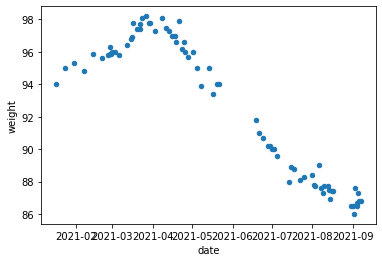

In [7]:
df.plot(x="date", y="weight", kind="scatter")

In [8]:
def ornstein_uhlenbeck_covariance_function(alpha, sigma):
    s2 = sigma**2 / (1-alpha)
    def cov_fun(t0, t1):
        return alpha ** np.abs(t1 - t0) * s2
    
    return cov_fun

In [9]:
def squared_quadratic_covaiance_function(length, c):
    def cov_fun(t0, t1):
        return c * np.exp(- 1/2 * ((t1 - t0) / length)**2) 
    
    return cov_fun
    

In [10]:
cov_fun = ornstein_uhlenbeck_covariance_function(alpha=1 - 1/10000, sigma=0.1)

In [51]:
cov_fun = squared_quadratic_covaiance_function(length=40, c=100)

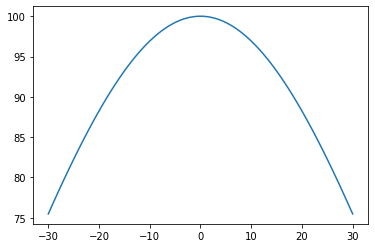

In [52]:
xxx = np.linspace(-30, 30, 100)
plt.plot(xxx, cov_fun(xxx, 0))

In [54]:
# variation of one measurement "observation variance"
obs_var = 0.2

# lon
mean_weight = 87

Denote by $x_1$ the observed times, $y_1$ the weight measurements, $f_1$ the real weights at the times $x_1$ and similarly $x_2, f_2$ the unobserved times and ideal weights.

In [55]:
x1 = np.array(df.day)
y1 = np.array(df.weight)
x2 = np.linspace(df.day.max(), df.day.min(), 100)

In [56]:
f2_mean, f2_cov = get_posterior_mean_cov(
    prior_mean=mean_weight, prior_cov_fun=cov_fun, obs_var=obs_var,
    x1=x1, y1=y1, x2=x2
)

In [57]:
f2_cov.diagonal()

array([0.04671173, 0.02521817, 0.02067226, 0.02382229, 0.0288267 ,
       0.0325293 , 0.03371926, 0.03244533, 0.02943525, 0.02565001,
       0.0219813 , 0.01908231, 0.01730843, 0.01673694, 0.01723292,
       0.01853226, 0.02031951, 0.02228721, 0.02417223, 0.02577121,
       0.02694215, 0.0276    , 0.02771321, 0.02730476, 0.0264575 ,
       0.02532036, 0.02410986, 0.02310164, 0.02260838, 0.02294399,
       0.02437778, 0.02708552, 0.03110678, 0.03631765, 0.04242617,
       0.04899391, 0.05548243, 0.06131841, 0.06596753, 0.06900494,
       0.07017071, 0.06940103, 0.06683024, 0.062764  , 0.05762912,
       0.05190927, 0.04607802, 0.04054046, 0.03559209, 0.03140037,
       0.02800907, 0.02536179, 0.02333767, 0.02179066, 0.02058422,
       0.01961538, 0.01882491, 0.01819402, 0.01773079, 0.01745161,
       0.01736305, 0.01744934, 0.01766806, 0.01795467, 0.01823407,
       0.01843567, 0.01850789, 0.01842826, 0.01820693, 0.01788275,
       0.01751346, 0.01716249, 0.01688589, 0.01672253, 0.01668

<ErrorbarContainer object of 3 artists>

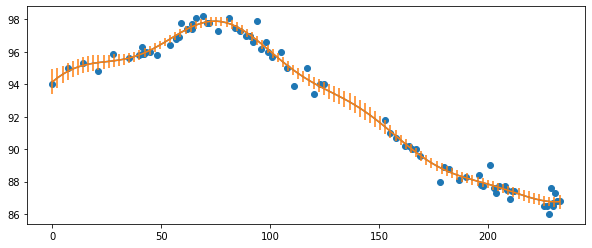

In [58]:
plt.figure(figsize=[10, 4])
plt.scatter(x1, y1)
plt.plot(x2, f2_mean)
plt.errorbar(x=x2, y=f2_mean, yerr=2*np.sqrt(f2_cov.diagonal()))


In [18]:
from gaussian_process_regression_utils import get_log_evidence

In [20]:
get_log_evidence(mean=mean_weight, cov_fun=cov_fun, obs_var=obs_var, x=x1, y=y1)

-89.0352337905264

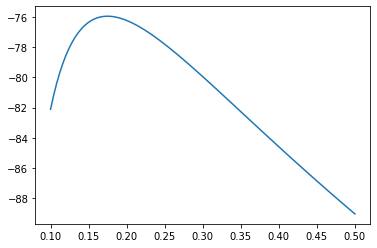

In [44]:
obs_var_grid = np.linspace(0.1, 0.5, 100)
evidence_grid = [
    get_log_evidence(mean=mean_weight, cov_fun=cov_fun, obs_var=obs_var, x=x1, y=y1)
    for obs_var in obs_var_grid
]

plt.plot(obs_var_grid, evidence_grid)

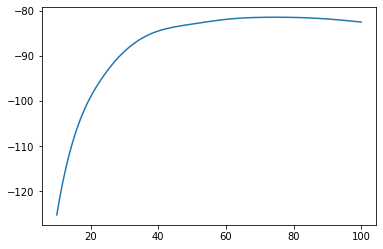

In [45]:
length_grid = np.linspace(10, 100, 100)
evidence_grid = [
    get_log_evidence(
        mean=mean_weight, 
        cov_fun=squared_quadratic_covaiance_function(length=length, c=100), 
        obs_var=obs_var, 
        x=x1, y=y1
    )
    for length in length_grid
]

plt.plot(length_grid, evidence_grid)

In [46]:
evidence_grid = [
    [
        get_log_evidence(
            mean=mean_weight, 
            cov_fun=squared_quadratic_covaiance_function(length=length, c=100), 
            obs_var=obs_var, 
            x=x1, y=y1
        )
        for obs_var in obs_var_grid
    ]
    for length in length_grid
]


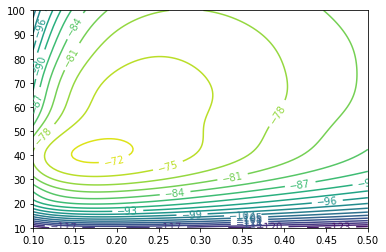

In [50]:
cs = plt.contour(obs_var_grid, length_grid, evidence_grid, levels=20)
cs = plt.clabel(cs)